In [1]:
from __future__ import division, print_function

import time, datetime

import numpy as np

from astropy.modeling import models
from astropy import units as u

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

## Exponential 

$$\frac{dn}{dm}=A 10^{a (m-\mu)}=A e^{a \ln(10) (m-\mu)}=A e^{\alpha (m-\mu)}$$ wher $\alpha \equiv a \ln(10)$

$$
N= \int^{m_2}_{m_1} A e^{\alpha(m-\mu)} dm = \left. \frac{A}{\alpha} e^{\alpha(m-\mu)} \right\rvert_{m_1}^{m_2}=
\frac{A}{\alpha} e^{-\alpha \mu} \left[ e^{\alpha m_2}-e^{\alpha m_1} \right]
$$

Now we get A for the [$m_1$, $m_2$] range:
$$
N=1 \rightarrow A=\frac{\alpha e^{\alpha \mu}}{e^{\alpha m_2}-e^{\alpha m_1}}
$$

So the final distribution from $m_1$ to $x$ is:
    $$
    N = \frac{e^{\alpha x}-e^{\alpha m_1}}{e^{\alpha m_2}-e^{\alpha m_1}} \rightarrow
    N (e^{\alpha m_2}-e^{\alpha m_1}) + e^{\alpha m_1} = e^{\alpha x} \rightarrow
    x = \frac{1}{\alpha} \ln{\left[ N (e^{\alpha m_2}-e^{\alpha m_1}) + e^{\alpha m_1} \right]}
    $$

In [3]:
def sample_lf(nsamples, alpha, m1, m2):
    N = np.random.rand(nsamples)
    expa1 = np.exp(alpha*m1)
    expa2 = np.exp(alpha*m2)
    return np.log(N*(expa2-expa1)+expa1)/alpha

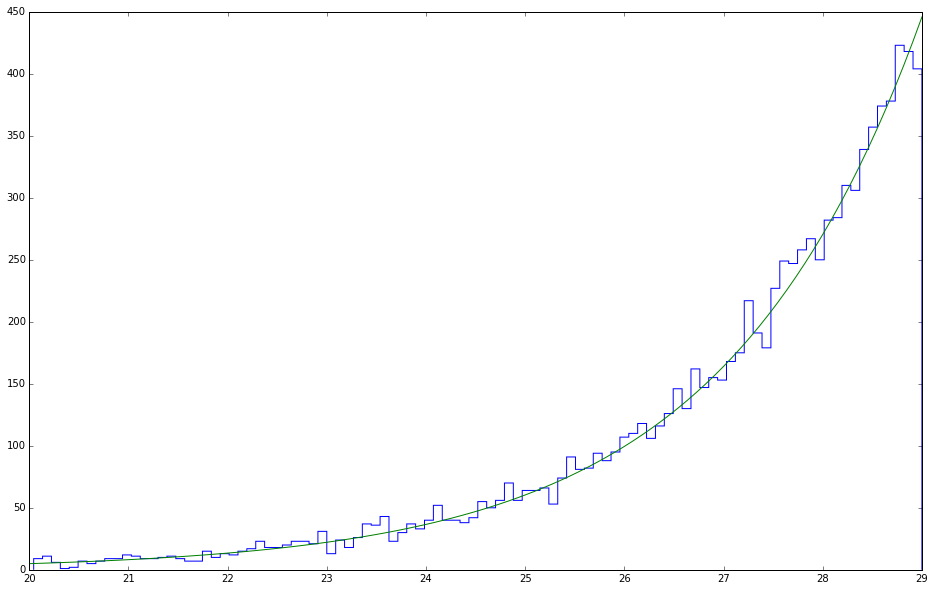

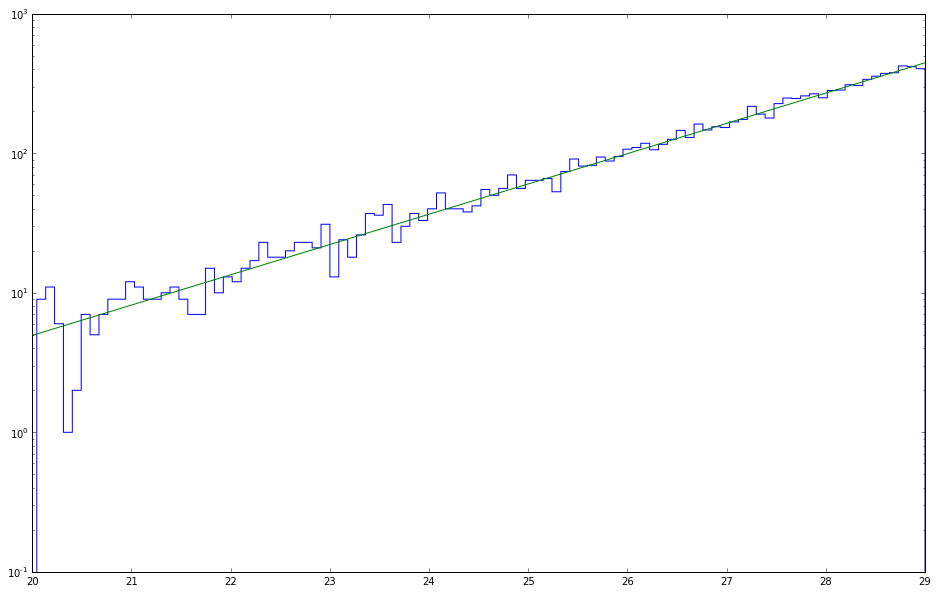

In [4]:
example_lf = sample_lf(10000, .5, 20, 29)
x = np.linspace(20, 29, 100)
y = np.exp(0.5*(x-16.8))

plt.figure()
plt.hist(example_lf, bins=100, histtype='step')
plt.plot(x, y)

plt.figure()
plt.hist(example_lf, bins=100, histtype='step', log=True)
plt.plot(x, y)
None

# Emceemr tests 

In [5]:
import emceemr
from emceemr import priors
import rgbmcmr

In [6]:
def make_fake_rgb(alpha, beta, mu, brightlimit, faintlimit, nmax, fracrgb):
    """
    
    returns mag0, isrgb
    """    
    #a = alpha + 1
    #b = beta + 1    
    #rgb = np.random.power(a, nmax)*(faintlimit-brightlimit) + brightlimit
    #foreground = np.random.power(b, nmax)*(faintlimit-brightlimit) + brightlimit
    
    rgb = sample_lf(nmax, alpha, brightlimit, faintlimit)
    foreground = sample_lf(nmax, beta, brightlimit, faintlimit)
    
    rgbmsk = rgb>mu
    fgmsk = foreground<mu
    rgb = rgb[rgbmsk]
    foreground = foreground[fgmsk]
    
    starting_fracrgb = len(rgb)/(len(foreground)+len(rgb))
    if starting_fracrgb>fracrgb:
        #too many RGBs
        nrgb = len(foreground)*fracrgb/(1-fracrgb)
        rgb = rgb[:nrgb]
    else:
        #too many fgs
        nfg = len(rgb)*(1-fracrgb)/fracrgb
        foreground = foreground[:nfg]
    
    mags = np.concatenate((rgb, foreground))
    isrgb = np.zeros(len(mags), dtype=bool)
    isrgb[:len(rgb)] = True
    
    unsorti = np.random.permutation(len(mags))
    mags = mags[unsorti]
    isrgb = isrgb[unsorti]
    
    return mags, isrgb

In [7]:
#median absolute deviation from ASTs
madmodel = models.Legendre1D(20, c0=-3954355396.3633738, c1=1353694208.4087687, c2=-124848799.79526304, c3=4897226.378521032, c4=-57041.00249220571, c5=-1549.1100474853888, c6=30.190195895799725, c7=1.1368681316643618, c8=-0.03563103282644921, c9=6.0712498989515646e-05, c10=4.892644246415783e-06, c11=8.248737934921185e-08, c12=-2.3350690477921424e-09, c13=-1.8352224226398223e-11, c14=5.350673251357965e-13, c15=2.4468515243894513e-15, c16=2.6121935517894807e-17, c17=-4.622081469223215e-18, c18=8.23871918441632e-20, c19=-6.005849952016176e-22, c20=1.6539943309668438e-24)

In [8]:
a = np.log(10)*.3
print('a=',a)
b = 1
mu = 24.6

realmags, isrgb = make_fake_rgb(a, b, mu, 21, 29, 5000, .99)

asterrfunc = lambda mags: madmodel(mags)*1.483
def complfunc(mag): #logistic function is a good fit to completeness
    x0=28.11463766268196
    w=-0.546193490253588
    t = (mag-x0)/w
    return 1/(1+np.exp(-t))

asterrs = asterrfunc(realmags)
asterrmags = realmags+np.random.randn(len(realmags))*asterrs

a= 0.690775527898


(20, 30)

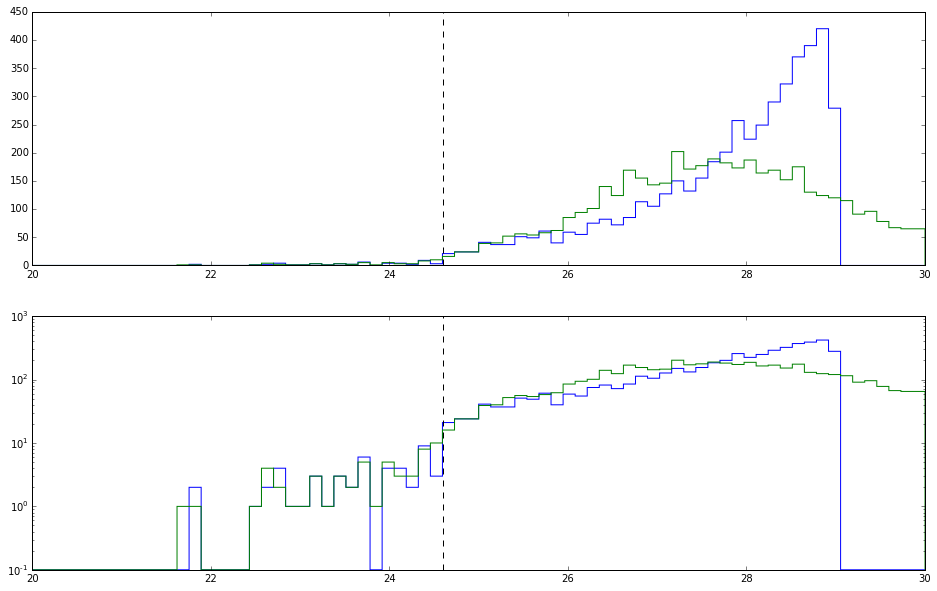

In [9]:
bs = np.linspace(20,30,75)

plt.subplot(2,1,1)
plt.hist(realmags,bins=bs,histtype='step')
plt.hist(asterrmags,bins=bs,histtype='step')
plt.axvline(mu, c='k', ls='--')
plt.xlim(20,30)

plt.subplot(2,1,2)
plt.hist(realmags,bins=bs,histtype='step', log=True)
plt.hist(asterrmags,bins=bs,histtype='step', log=True)
plt.axvline(mu, c='k', ls='--')
plt.xlim(20,30)

(462, 414, 48, 510)

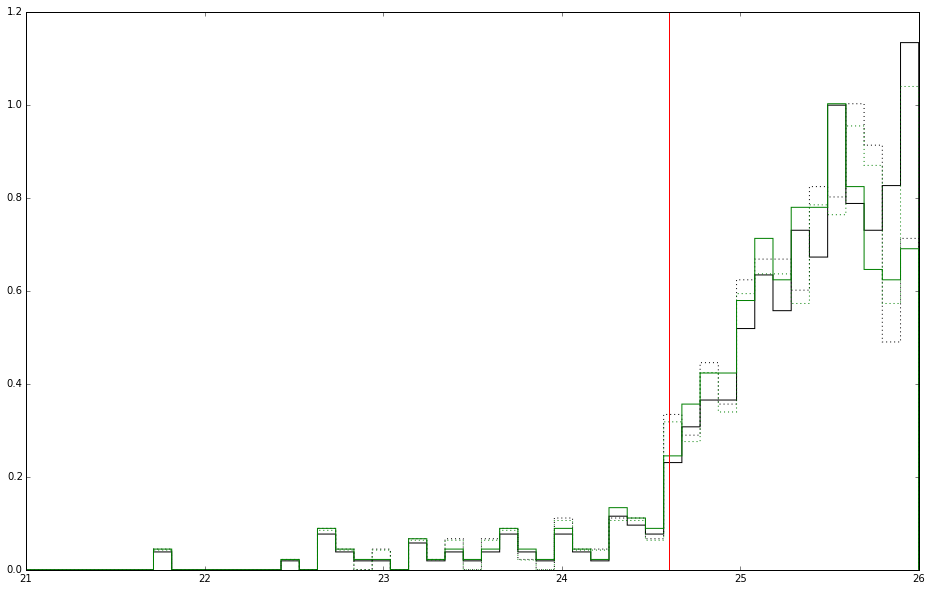

In [10]:
bins = np.linspace(21,26,50)

inwindow_real = (bins[0]<realmags)&(realmags<bins[-1])
inrgbwindow_real = inwindow_real&(realmags>mu)
inotherwindow_real = inwindow_real&(realmags<mu)

inwindow = (bins[0]<asterrmags)&(asterrmags<bins[-1])


plt.hist(realmags[inwindow], bins=bins,histtype='step',normed=True, ls='dotted', color='k')
plt.hist(asterrmags[inwindow], bins=bins,histtype='step',normed=True, color='k')


plt.hist(realmags[inwindow_real], bins=bins,histtype='step',normed=True, ls='dotted', color='g')
plt.hist(asterrmags[inwindow_real], bins=bins,histtype='step',normed=True, color='g')


#plt.hist(realmags[inrgbwindow_real], bins=bins,histtype='step',normed=True, ls='dotted', color='r')
#plt.hist(asterrmags[inrgbwindow_real], bins=bins,histtype='step',normed=True, ls='dashed', color='r')

#plt.hist(realmags[inotherwindow_real], bins=bins,histtype='step',normed=True, ls='dotted', color='b')
#plt.hist(asterrmags[inotherwindow_real], bins=bins,histtype='step',normed=True, color='b')


plt.axvline(mu,color='r')
np.sum(inwindow_real), np.sum(inrgbwindow_real), np.sum(inotherwindow_real), np.sum(inwindow)

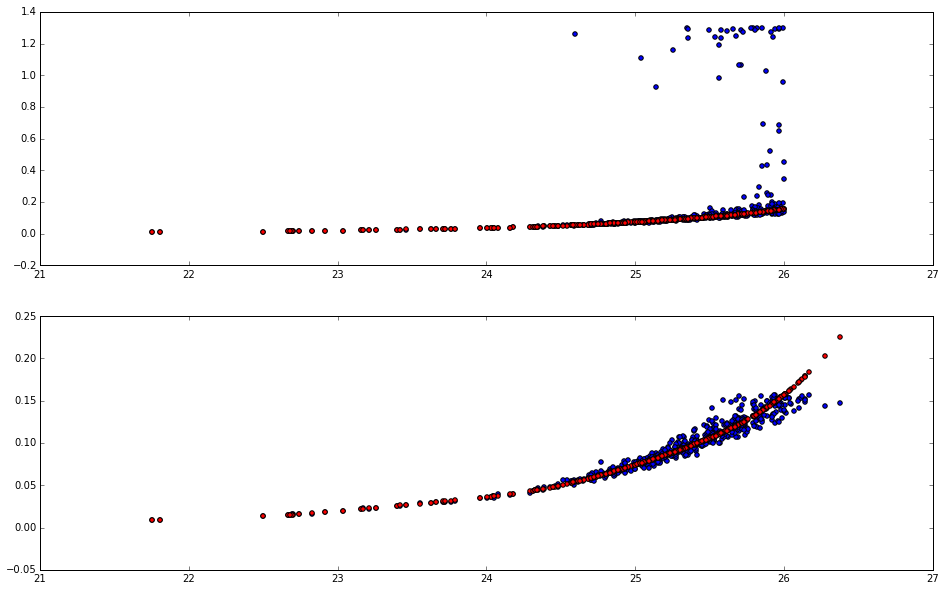

In [11]:
plt.subplot(2,1,1)
plt.scatter(asterrmags[inwindow], asterrs[inwindow])
plt.scatter(asterrmags[inwindow], madmodel(asterrmags[inwindow])*1.483,c='r')

plt.subplot(2,1,2)
plt.scatter(asterrmags[inwindow_real], asterrs[inwindow_real])
plt.scatter(asterrmags[inwindow_real], madmodel(asterrmags[inwindow_real])*1.483,c='r')

## Now do test runs of the MCMC

In [12]:
pris = dict(tipmag=priors.UniformPrior(23, 25.5),
            alphargb=priors.UniformPrior(0, 2), 
            alphaother=priors.UniformPrior(0, 2),
            fracother=priors.UniformPrior(0,0.5))

### "Intrinsic" mags 

In [13]:
astmod = rgbmcmr.RGBModel(realmags[inwindow_real], None, priors=pris)

In [14]:
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(5000, burnin=1000)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-12-07 19:38:33.250284
Took 0.1105818669 min


Acors:
tipmag: 56.6617865346
alphargb: 44.504466036
alphaother: 56.5072844905
fracother: 45.0205439951
Acceptance Fractions:
[ 0.5534,  0.533 ,  0.5616,  0.551 ,  0.5462,  0.5274,  0.5316,  0.5492,
  0.5502,  0.542 ,  0.5408,  0.565 ,  0.55  ,  0.5288,  0.5438,  0.5144]


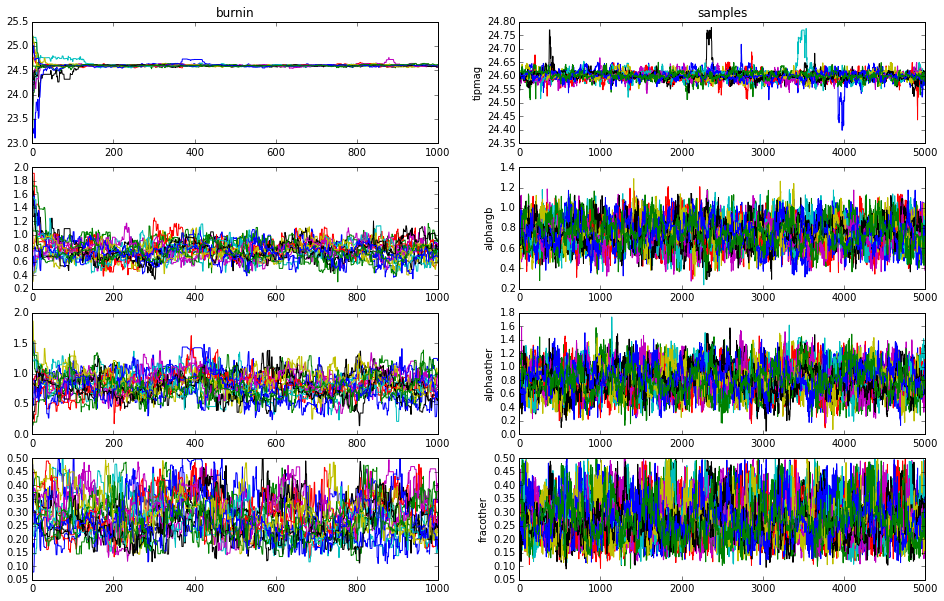

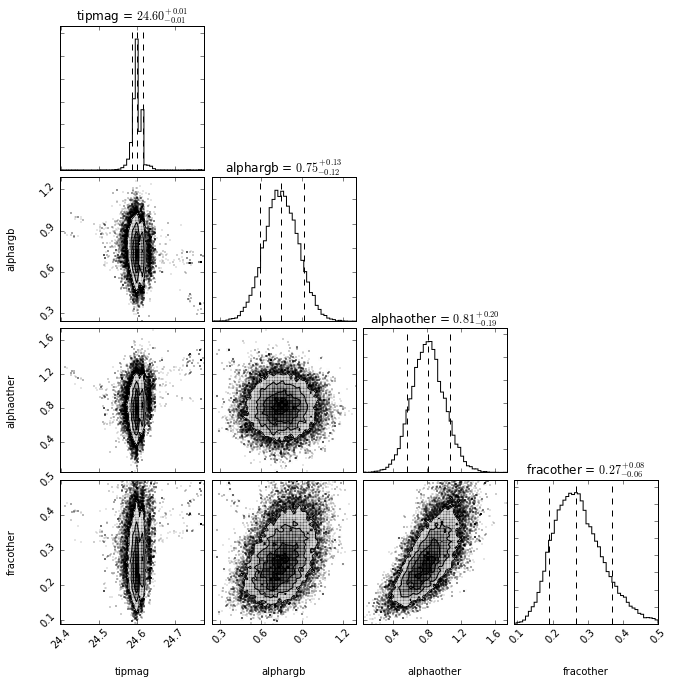

In [15]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

rgbmcmr.py:198: RuntimeWarning: divide by zero encountered in log
  plt.scatter(cens, np.log(n/N), **datakwargs)


(-5, 0)

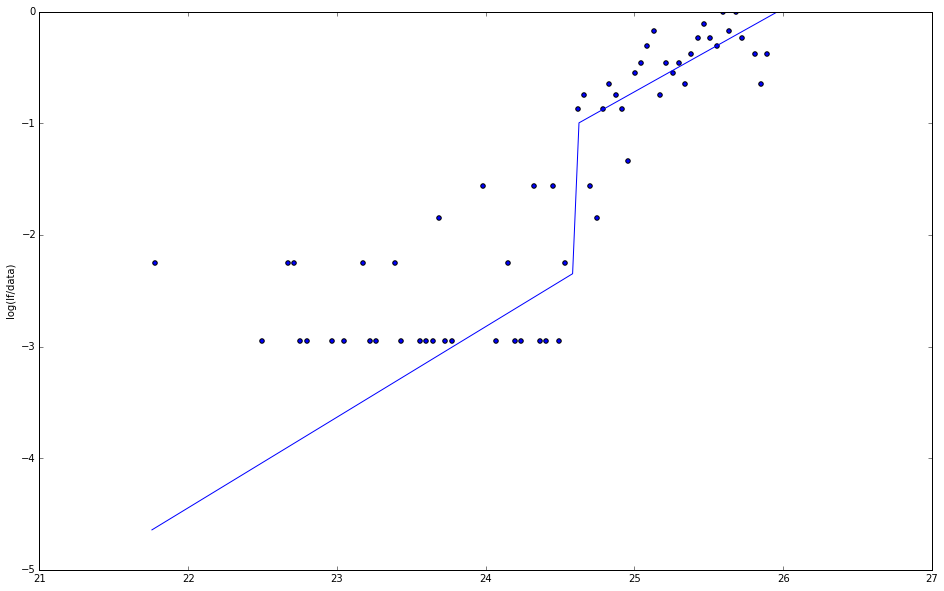

In [16]:
astmod.plot_data_and_model(sampler)
plt.ylim(-5,0)

### With AST 

In [17]:
astmod = rgbmcmr.RGBModel(asterrmags[inwindow], madmodel(asterrmags[inwindow])*1.483, priors=pris)

In [18]:
#experimental timing run
st = time.time()
sampler = astmod.initialize_and_sample(15, burnin=5)
et = time.time()
dt = (et - st)*u.second
    
ntarg = 6000
print('20 samples took', dt, 'which scales up to',ntarg,'samples in',(dt*ntarg/20).to(u.minute))

20 samples took 0.156107187271 s which scales up to 6000 samples in 0.780535936356 min


In [19]:
#now the real deal
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(5000, burnin=1000)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-12-07 19:38:44.256469
Took 0.685458830992 min


Acors:
tipmag: 40.4520205704
alphargb: 42.9141773712
alphaother: 35.93346086
fracother: 47.6578192088
Acceptance Fractions:
[ 0.5806,  0.5814,  0.5802,  0.5846,  0.5794,  0.5906,  0.5752,  0.5872,
  0.5834,  0.5804,  0.579 ,  0.5772,  0.5822,  0.5722,  0.5742,  0.5742]


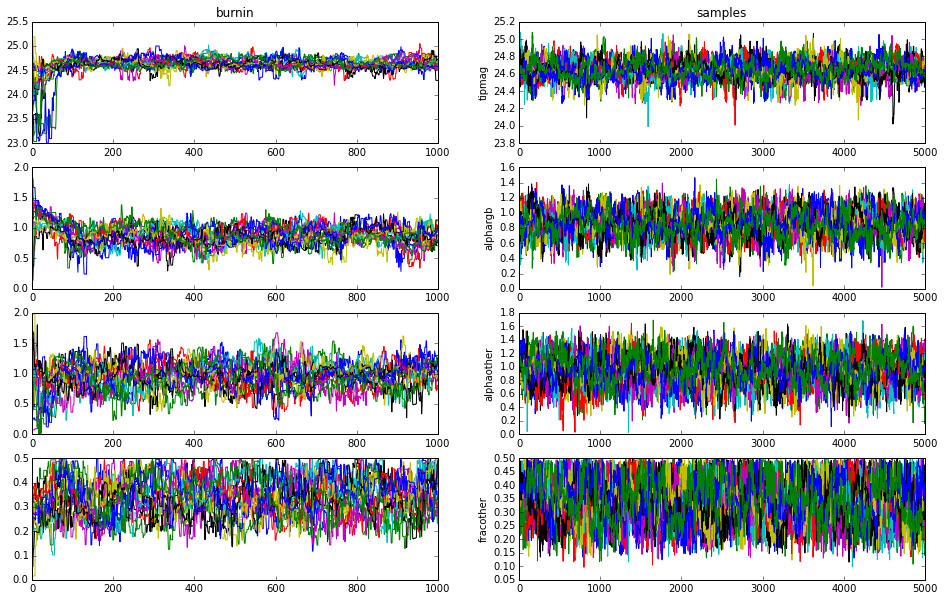

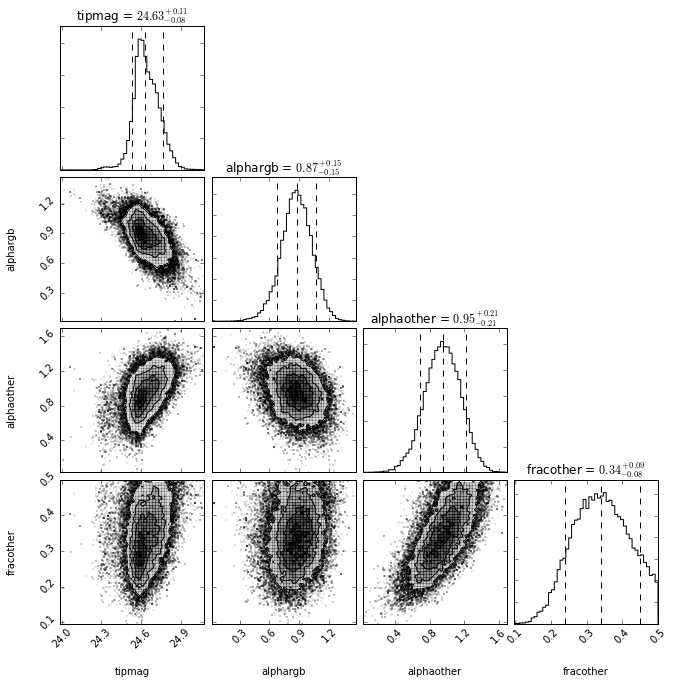

In [20]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

(-5, 0)

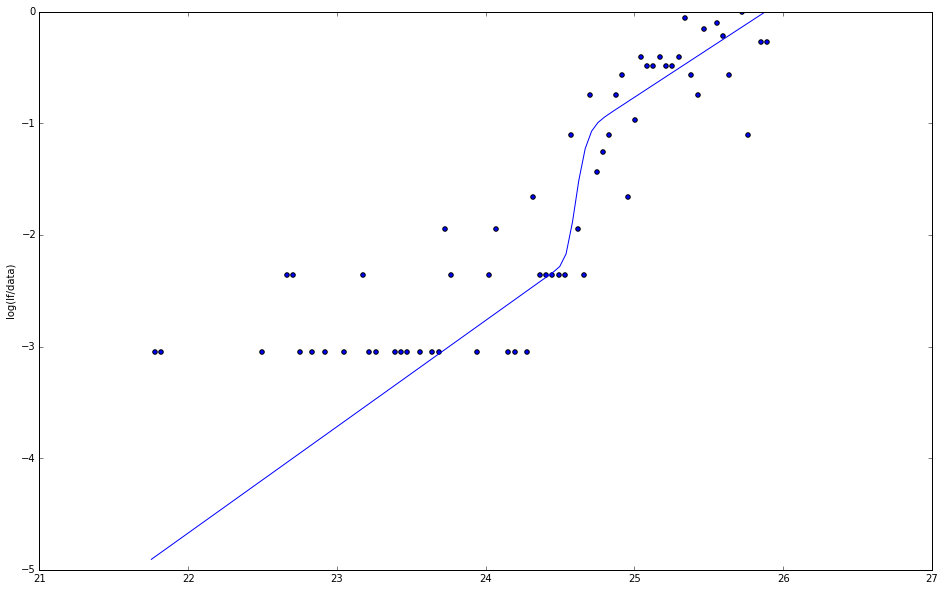

In [21]:
astmod.plot_data_and_model(sampler)
plt.ylim(-5,0)

## Test with the  function models

487

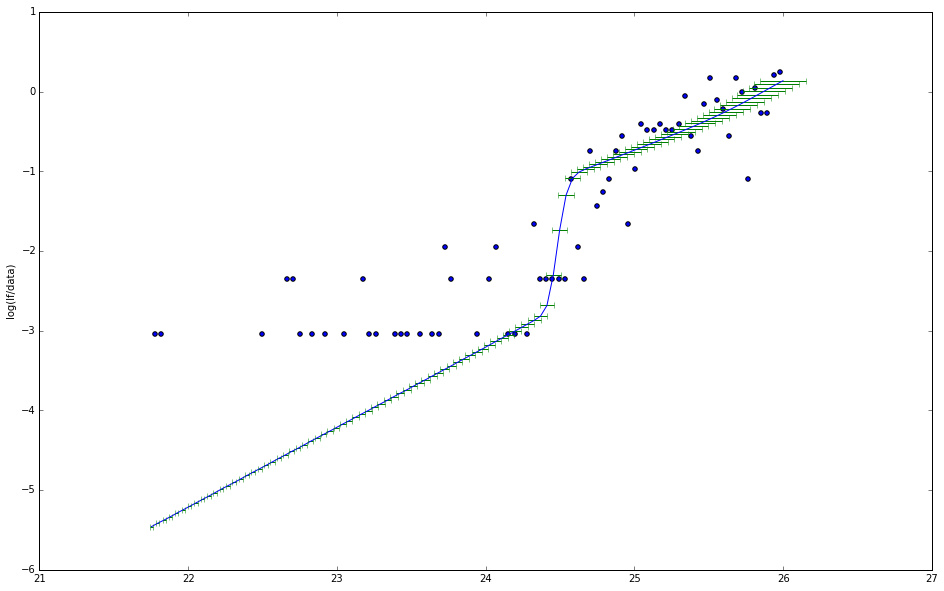

In [36]:
astmod = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          funcmags=rgbmcmr.RGBModel.AutoFuncmags(21, 29, 0.75), 
                          #funcmags = np.linspace(21, 29,100),
                          uncfunc=asterrfunc,
                          priors=pris,
                          complfunc=complfunc)
samples = 5000
burnin = 1000

md, lnp = astmod.plot_lnprob(24.5,.7,1,.2,doplot=False)
astmod.plot_data_and_model([24.5,.7,1,.2])
plt.errorbar(md, lnp, None, astmod.uncfunc(md), fmt=None)
len(astmod.funcmags)

In [37]:
#experimental timing run
st = time.time()
sampler = astmod.initialize_and_sample(15, burnin=5)
et = time.time()
dt = (et - st)*u.second
    
nallsamps = burnin+samples
print('20 samples took', dt, 'which scales up to',nallsamps,'samples in',(dt*nallsamps/20).to(u.minute))

20 samples took 3.91190099716 s which scales up to 6000 samples in 19.5595049858 min


In [38]:
#now the real deal
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(samples, burnin=burnin)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-12-07 20:30:06.292155
Took 17.6953541358 min


Acors:
tipmag: 44.6633772556
alphargb: 44.1809665048
alphaother: 49.2092910186
fracother: 45.7434656012
Acceptance Fractions:
[ 0.5688,  0.5732,  0.579 ,  0.5652,  0.5614,  0.5564,  0.573 ,  0.5628,
  0.5656,  0.5706,  0.5672,  0.5578,  0.5582,  0.574 ,  0.578 ,  0.5748]


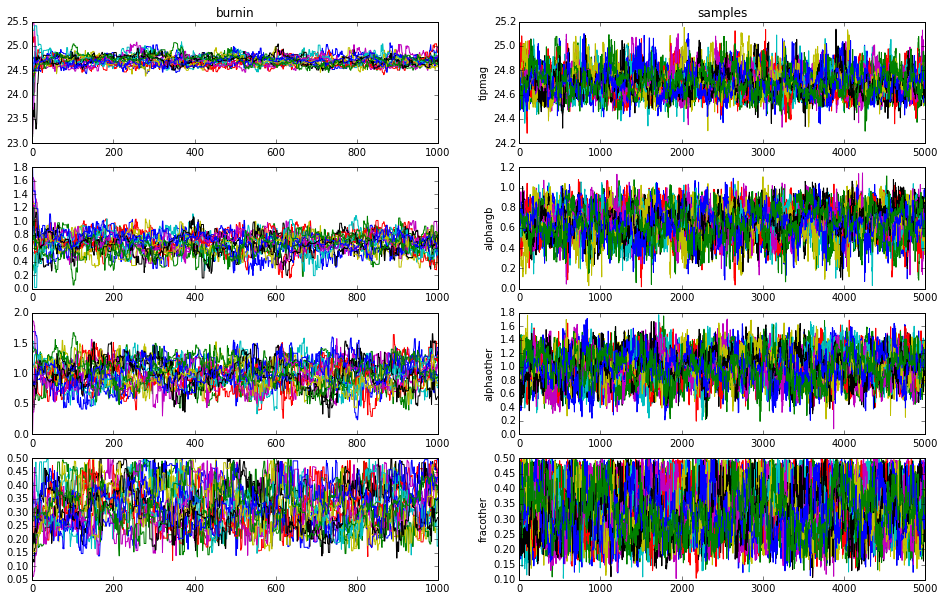

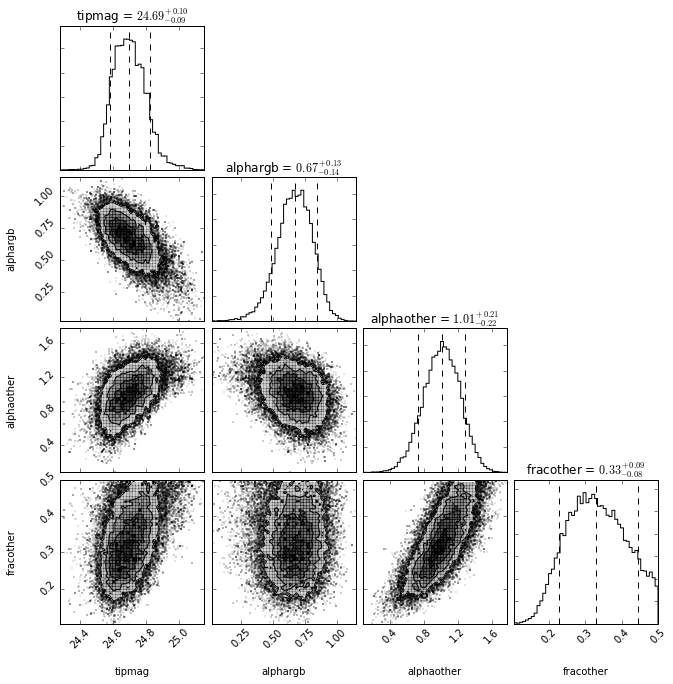

In [39]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

Acors:
tipmag: 55.2373915363
alphargb: 49.2134561222
alphaother: 56.0553046846
fracother: 52.5174518027
Acceptance Fractions:
[ 0.534 ,  0.5168,  0.5532,  0.5482,  0.5488,  0.5398,  0.5254,  0.5354,
  0.5282,  0.5392,  0.544 ,  0.5488,  0.5196,  0.5412,  0.5282,  0.5354]


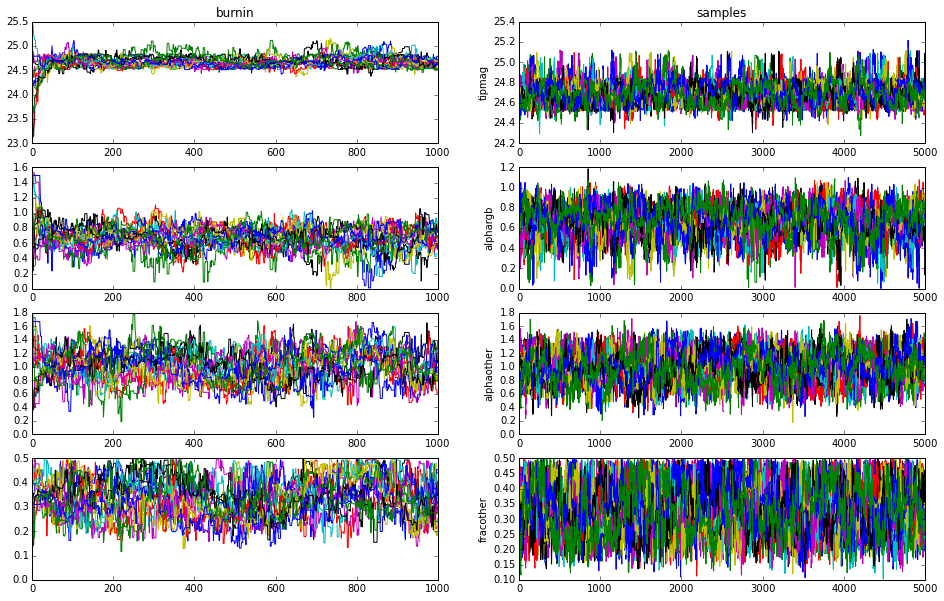

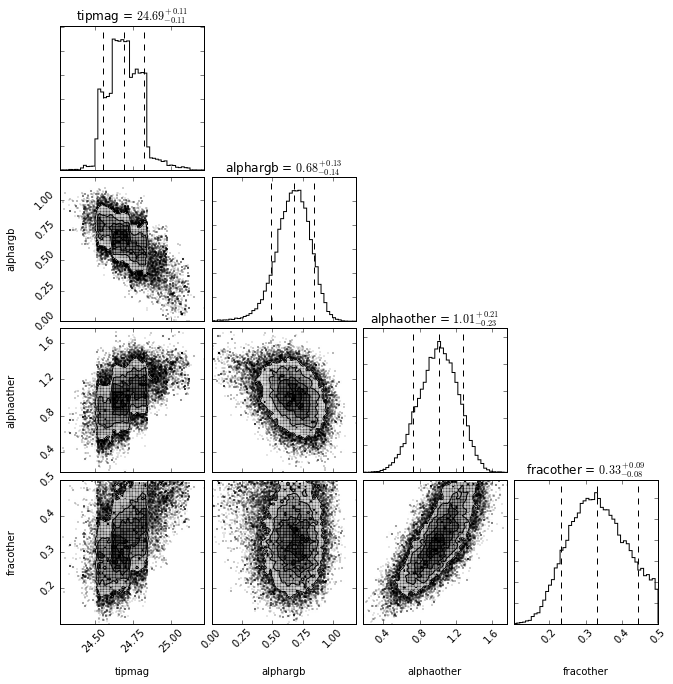

In [25]:
#OLDONE w/ uncspacing = 20

(-5, 0)

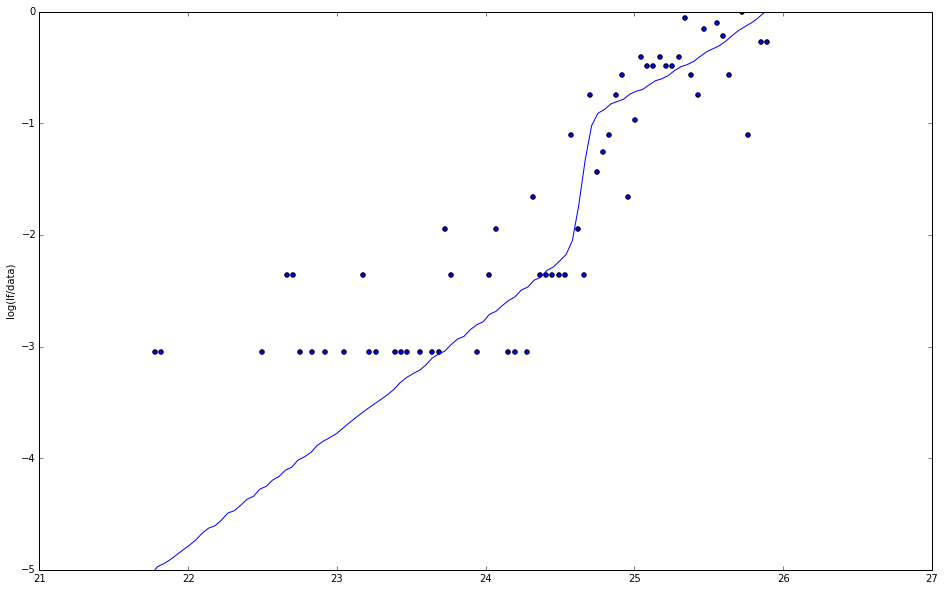

In [26]:
astmod.plot_data_and_model(sampler)
plt.ylim(-5,0)

## Show LF models for fiducial case

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log


(0.99959460524985966, 0.98913979957481468, 1.0003850951576601)

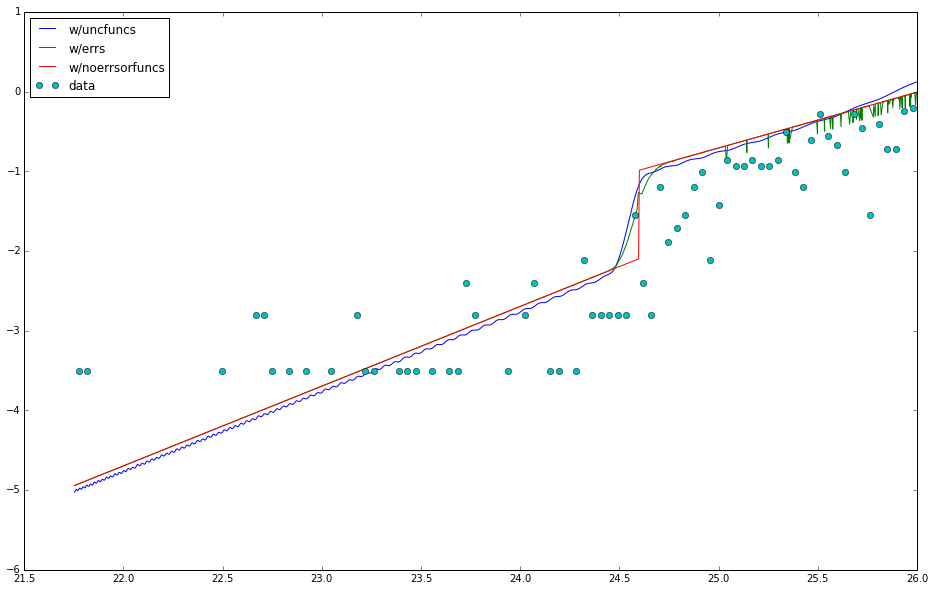

In [27]:
tipmag0 = 24.6
alpha0 = 0.7
beta0 = 1.
frac0 = .33

astmod1 = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          funcmags=rgbmcmr.RGBModel.AutoFuncmags(21, 29, 2), 
                          #funcmags = np.linspace(21, 29,100),
                          uncfunc=asterrfunc,
                          complfunc=complfunc,
                          priors=pris)
m1, lnp1 = astmod1.plot_lnprob(tipmag0, alpha0, beta0, frac0, 1000)

astmod2 = rgbmcmr.RGBModel(asterrmags[inwindow], asterrs[inwindow],
                          priors=pris)
m2, lnp2 = astmod2.plot_lnprob(tipmag0, alpha0, beta0, frac0, astmod2.magdata)

astmod3 = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          priors=pris)
m3, lnp3 = astmod3.plot_lnprob(tipmag0, alpha0, beta0, frac0, 1000)

nh, bh = np.histogram(astmod1.magdata, bins=100)
plt.plot((bh[1:]+bh[:-1])/2, np.log(nh)-3.5,'o')

plt.legend(['w/uncfuncs', 'w/errs','w/noerrsorfuncs', 'data'],loc=0)
np.trapz(x=m1,y=np.exp(lnp1)), np.trapz(x=m2,y=np.exp(lnp2)), np.trapz(x=m3,y=np.exp(lnp3))

# Numerical derivative tests 

In [28]:
from scipy.stats import norm
from scipy.special import erf

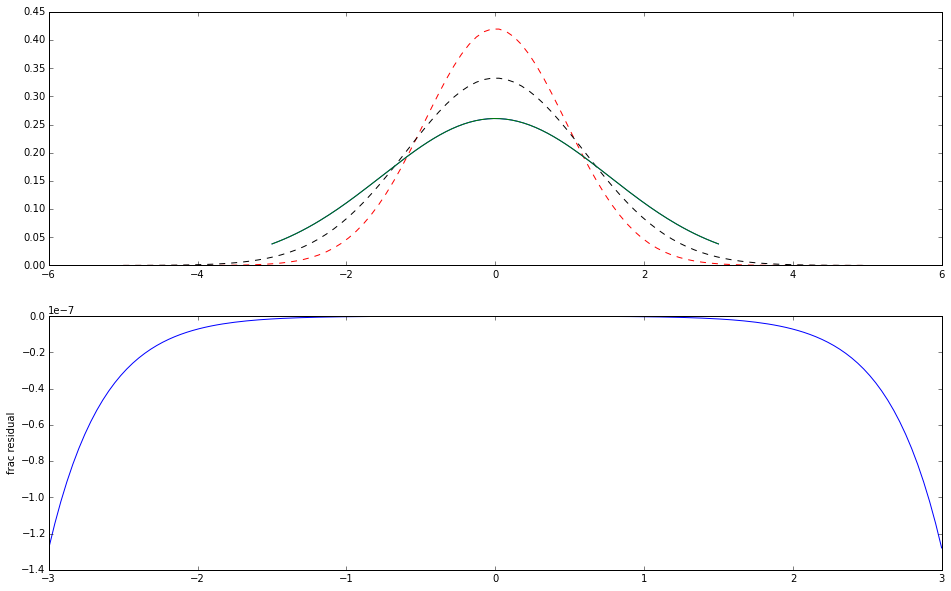

In [29]:
#two gaussians convolved
s1 = 0.95
s2 = 1.2
s12 = np.hypot(s1, s2)

norm1 = norm(scale=s1)
norm2 = norm(scale=s2)
norm12 = norm(scale=s12)

x = np.linspace(-5,5, 100) # integrate over this
y = np.linspace(-3,3, 150) # the independent variable
xr = x.reshape(x.size, 1)
yr = y.reshape(1, y.size)
integ = np.trapz(norm1.pdf(xr)*norm2.pdf(xr-yr), x, axis=0)

plt.subplot(2,1,1)
plt.plot(x, norm1.pdf(x), '--r')
plt.plot(x, norm2.pdf(x), '--k')
plt.plot(y, integ, c='b')
plt.plot(y, norm12.pdf(y), c='g')

plt.subplot(2,1,2)
true = norm12.pdf(y)
plt.plot(y, (integ-true)/true)
plt.ylabel('frac residual')
None

In [30]:
x=np.linspace(-6,6,100)
y = np.exp(-x**2/2)*(2*np.pi)**-0.5 *np.array([3,2,1]).reshape(3,1)
np.trapz(y,x.reshape(100),axis=1),x.shape,y.shape

(array([ 2.99999999,  2.        ,  1.        ]), (100,), (3, 100))

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


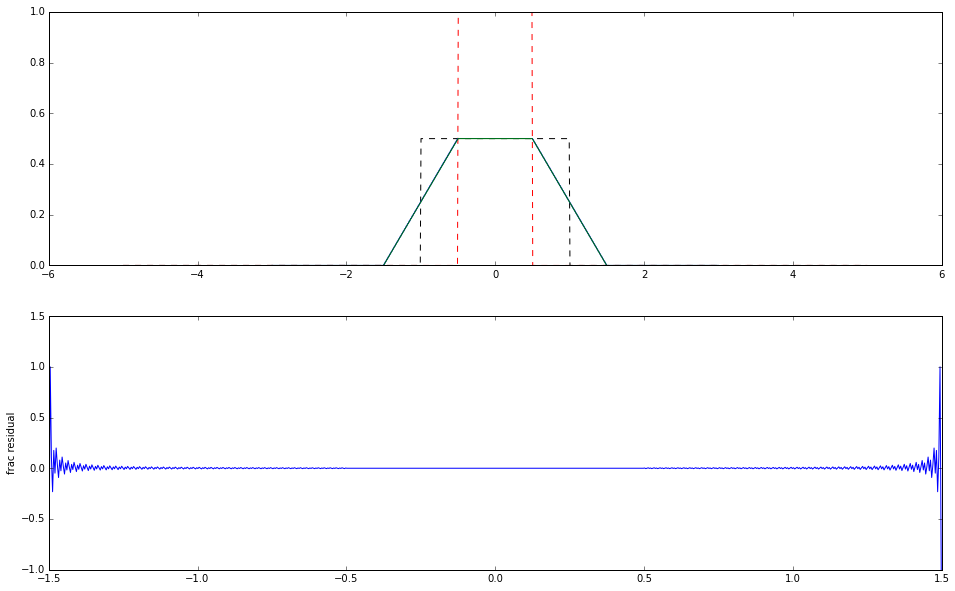

In [31]:
#square w/square
w1 = 1.
w2 = 2.0

def make_theta(x, w, cen=0):
    theta = np.ones_like(x)/w
    theta[x>(cen+w/2.)] = 0
    theta[x<(cen-w/2.)] = 0
    return theta

x = np.linspace(-5,5, 1000) # integrate over this
y = np.linspace(-3,3, 1500) # the independent variable
xr = x.reshape(x.size, 1)
yr = y.reshape(1, y.size)

theta = make_theta(xr, w1)
theta2 = make_theta(xr, w2)
theta2_integ = make_theta(xr-yr, w2)

integ = np.trapz(theta*theta2_integ, xr, axis=0)

#theta with triangles
outer_edge = (w1+w2)/2
inner_edge = np.ptp([w1,w2])/2
true = make_theta(y, inner_edge*2)*inner_edge
slope = 0.5/(inner_edge-outer_edge)
true[y>inner_edge] = (y[y>inner_edge]-outer_edge)*slope
true[y>outer_edge] = 0

true[y<-inner_edge] = (y[y<-inner_edge]+outer_edge)*-slope
true[y<-outer_edge] = 0

plt.subplot(2,1,1)
plt.plot(x, theta.ravel(), '--r')
plt.plot(x, theta2.ravel(), '--k')
plt.plot(y, integ, c='b')
plt.plot(y, true, c='g')

plt.subplot(2,1,2)
plt.plot(y, (integ-true)/true)
plt.ylabel('frac residual')